In [1]:
# Import
import numpy as np
from numpy.linalg import inv
import scipy as sci
import control
from scipy.signal import place_poles, StateSpace, lsim
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt
from sim import *
pi = np.pi

In [2]:
# Parameters
mu = 3968600 * 1000**3 # gravitational const (m^3/s^2)
R_e = 6.378e6 # radius of the earth (m)
h_sat = 700 * 1000 # Altitude of s/c (m)
r0 = R_e + h_sat # Init radius
v0 = 0
theta0 = 0
omega0 = np.sqrt(mu/r0**3)

Period = 2*pi*np.sqrt(r0**3/mu)
tspan = [0, 5*Period]
teval = np.linspace(tspan[0], tspan[1], 200)

X0 = np.array([r0, v0, theta0, omega0])

## Define SS

RE = 6378 # km
ROrb = 300 # km
r0 = RE + ROrb
mu = 398600


A = np.array([[           0, 1, 0,                0],
                [3*mu/(r0**3), 0, 0, 2*np.sqrt(mu/r0)],
                [ 0, 0, 0, 1],
                [0, -2*np.sqrt(mu/r0**5), 0, 0 ]])

B = np.array([[0,0],
                [1,0],
                [0,0],
                [0,1/r0]])

C = np.array([[1,0,0,0],[0,0,1,0]])

D = np.zeros([2,2])

## Define Reference Input and Constant Disturbance force

# Period of orbit
T = 2*pi*np.sqrt(r0**3/mu)

# Define simulation time to be 3 orbital periods
tvec = np.linspace(0,3*T,round(30*T))

omega_des = np.sqrt(mu/(r0**3))


# Define reference input

ref = np.vstack((np.zeros(len(tvec)), [omega_des] * tvec))
#ref = np.zeros(len(tvec))

# Define a disturbance profile
d = np.zeros([2,len(tvec)])

# For now, random constant disturbance
d[1,:] = -0.0001


G = np.array([[0,0],[1,0],[0,0],[0,1/r0]])

# Noise values
range_eta = 0.1 # m - 1 sigma
theta_eta = 0.0004 # rad - 1 sigma


In [3]:
## Solve ricatti equation for LQR

def solve_ARE(A,B,Q,R):
    """
        Returns K matrix, solution to algebraic ricatti equation P, and CL evals
    """

    # Solve ARE
    P = solve_continuous_are(A,B,Q,R)

    # Compute LQR gain
    K = np.linalg.inv(R) @ B.T @ P
    
    # Closed loop evals
    evals = np.linalg.eigvals(A - B @ K)

    return K, P, evals

In [4]:
## Augmented State Space, integral control

AaugOL = np.block([[A, np.zeros([4,2])],[-C, np.zeros([2,2])]])
BaugOL = np.block([[B],[np.zeros([2,2])]])
CaugOL = np.block([C, np.zeros([2,2])])
DaugOL = np.zeros([2,4])

# Tuning knobs
max_r = 0.01
max_rdot = 0.1
max_theta = 0.01
max_thetadot = 0.1
max_integral = 0.1

# Don't care as much as about controlling rdot and theta dot
r_wt = 0.3
rdot_wt = 0.1
theta_wt = 0.3
thetadot_wt = 0.1
integral_wt = 0.2


max_u = 0.0005
ctr_wt = 0.5

Q = np.diag([r_wt**2/max_r**2,rdot_wt**2/max_rdot**2,theta_wt**2/max_theta**2,thetadot_wt**2/max_thetadot**2,integral_wt**2/max_integral**2,integral_wt**2/max_integral**2])
R = 10*np.diag([ctr_wt**2/max_u**2,ctr_wt**2/max_u**2])

# Solve ARE
K, P, evals = solve_ARE(AaugOL,BaugOL,Q,R)

AaugCL = AaugOL - BaugOL@K
BaugCL = np.block([[np.zeros([4,2]),G],[np.array([[1,0],[0,1]]),np.zeros([2,2])]])

sys = StateSpace(AaugCL,BaugCL,CaugOL,DaugOL)

In [5]:
## Create Observer

np.set_printoptions(precision=2)
## Create Observer

# Check poles
# V,D = np.linalg.eig(A)
# for eig in V:
#     print(eig)

# print(D)

des_poles = np.array([-0.005, -0.01 + 0.001j, -0.01 - 0.001j, -0.02,0,0])
res = place_poles(np.transpose(AaugOL),np.transpose(CaugOL),des_poles)
L_T = res.gain_matrix
L = np.transpose(L_T)


2000


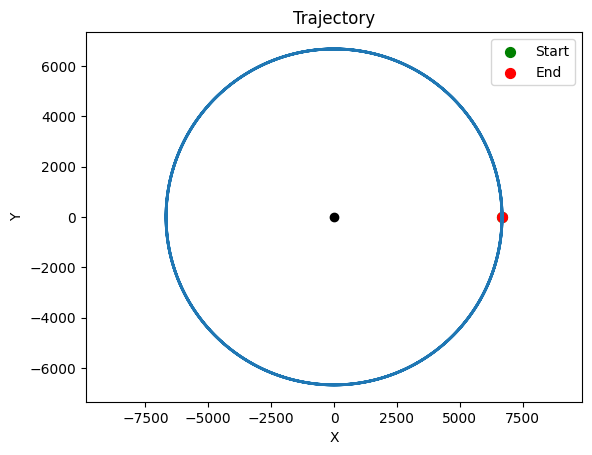

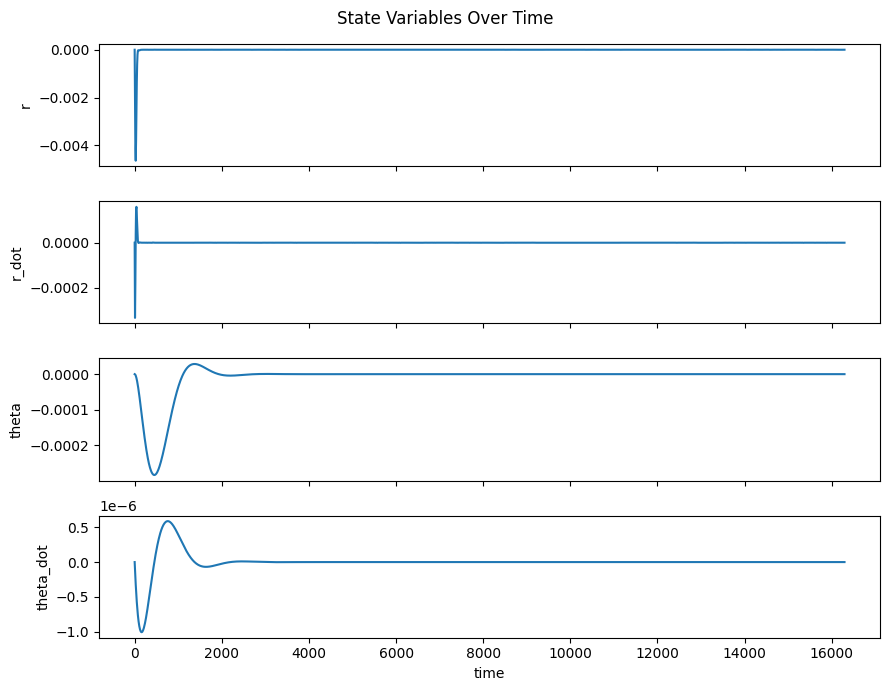

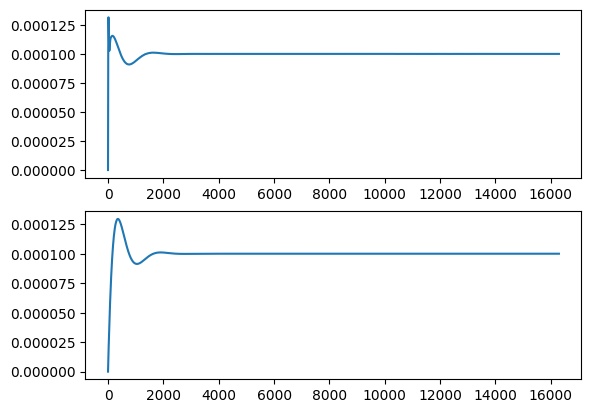

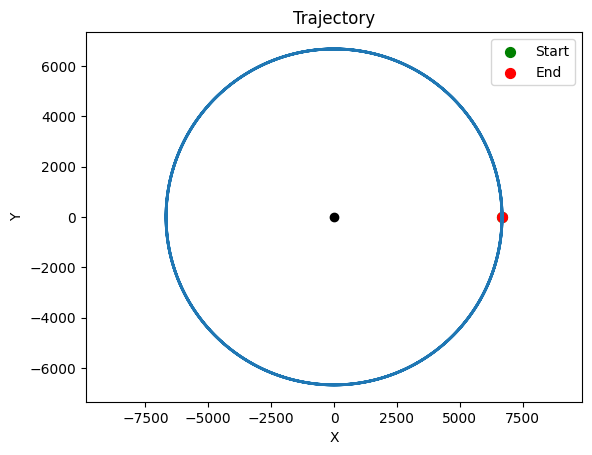

In [6]:
## Linearized Dynamics fxn with observer in place
def contr_func(X, K):
    return -K@X

def state_compensator(t,sys,K,L,X,Ufxn):

    
    A = sys.A
    B = sys.B
    C = sys.C
    D = sys.D

    n = A.shape[0]
    x = X[:n]
    x_hat = X[n:]

    u = Ufxn(x_hat,K)

    ref = [0, 0]
    d = np.array([-1e-4,-1e-4])

    U = np.concatenate([ref,d]).T

    y = C@x
    y_hat = C@x_hat

    x_dot = A@x + B@U
    x_hat_dot = A @ x_hat + B @ U + L @ (y - y_hat)

    return np.concatenate([x_dot,x_hat_dot])

dyn = lambda t,X: state_compensator(t,sys,K,L,X,contr_func)

tspan = [tvec[0], tvec[-1]]
res = 2000
X0 = np.array([0,0,0,0,0,0,0,0,0,0,0,0]).T

teval = np.linspace(tspan[0],tspan[1],res)
print(len(teval))
sol = sci.integrate.solve_ivp(dyn,tspan,X0, t_eval=teval)

X = sol.y
t = sol.t
x_real = X[:6]
x_obs = X[6:]
U = -K@x_obs

plot_state(x_real,t)


fig,ax = plt.subplots(2,1)
ax[0].plot(t,U[0,:])
ax[1].plot(t,U[1,:])

X_ref = np.array([r0*np.ones(len(t)),np.zeros(len(t)),omega_des*t,omega_des*np.ones(len(t))])
plot_XY(x_obs[0:4] + X_ref)


